| | |
|:----------|:----------|
| Name      | Bayesian Modeling |
| Notebook  | Change Point Detection |
| Author    | Joshuah Touyz, PhD |
| Version   | 0.1 |
|Last update| 02/29/20 |

# Change point analysis - getting started with PyMC3

Problem statement: 
- Suppose you are an ad agency and wanted to understand when there was a change in cusomter behavior due to a change in the website
- Unfortunately you do not know when this change to the website occured but are aware that it occured in the last 70 days
- You are given a graph of the number of clicks you are asked to identify when the change took place and how large it was

Goal:
- Design an algorithm that detects when a change in a system took place
- Identify the means from the system 

Output:
- The distribution of probable times a change occured in a given system
- The rates before, during and after the change in the system

General applications
- Change point detection is used anywhere we are seeking to find where there was a change in a systems behavior
- The most famous use case is in Facebook's Prophet software for forecasting
- Other use cases involve 
    - Identifying when a law went into effect and the concomitant behavior
    - The average change in behavior due to an intervention

In [10]:
# Load libraries
import numpy as np
from numpy.linalg import inv 
import scipy as sp
import pandas as pd
import os

# Plotting libarires
import plotnine as pn
from plotnine import *
import corner 

# Importing pymc3
import pymc3 as pm

# Supressing warnings
import warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings("default")

Formulation 1:

$$
\lambda_1\sim exp(\alpha)\\
\lambda_2\sim exp(\alpha)\\
\tau\sim Unif(0,day_{max})\\
\lambda_{t}=\begin{cases} \lambda_1 &\mbox{ if }t\leq\tau\\ \lambda_2 &\mbox{ if } t>\tau\end{cases}\\
Count_{t}\sim Poisson(\lambda_{t})
$$

### Loading the data

In [13]:
# Loading data
home = os.environ['HOME']
path_to_data = os.path.join(home,'Desktop/UpSkill/Workshops/Workshop/observed_counts.csv')
count_data = pd.read_csv(path_to_data).rename({'x':'time','y':'observed_counts'},axis=1)
count_data.head()

,observed_counts,time
0,6,1
1,8,2
2,17,3
3,8,4
4,11,5


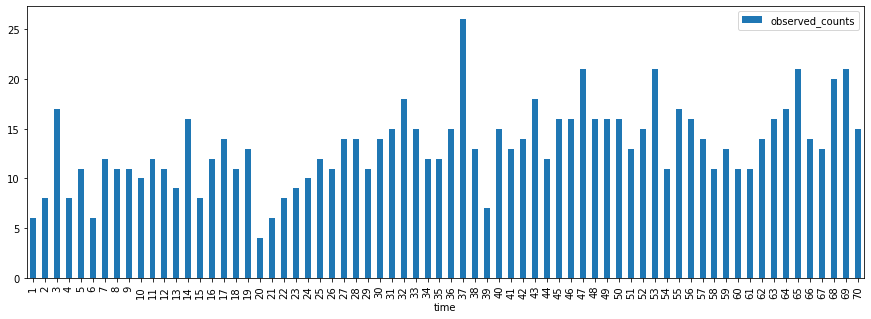

In [14]:
# Visualize the data
count_data.plot(x = 'time', y ='observed_counts',  kind = 'bar', figsize=(15,5))

Looking at the graph it is not clear at all when the change took place

### Building the model

In [15]:
# Setting up constants
mean_of_counts = count_data.observed_counts.mean()
alpha = 1.0/mean_of_counts
l = len(count_data)

In [16]:
# - Defining the base stochastic parameters in the model - 
model = pm.Model()

with model:

    lambda_1 = pm.Exponential('lambda_1',alpha)
    lambda_2 = pm.Exponential('lambda_2',alpha)

    tau = pm.DiscreteUniform('tau',lower = 0, upper= l-1)

In [17]:
# - Defining how lambda switches - 
with model:
    idx = count_data.time
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2) # This is a deterministic function

In [18]:
# - Relating our data to the model -
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data.observed_counts)

In [19]:
# - Running sampler -
chains = 4
samples = 10000

with model:
    step = pm.Metropolis()
    trace = pm.sample(draws = samples, 
                      chains = chains, 
                      tune=5000,
                      step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6708.46draws/s]
The number of effective samples is smaller than 25% for some parameters.


### What does the distribution of our parameters look like?

In [21]:
# - Posterior values -
lambda_1_samples =  trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

# - Posterior distribution -
posterior_dist = pd.DataFrame({'lambda_1': lambda_1_samples, 'lambda_2': lambda_2_samples, 'tau' : tau_samples})
posterior_dist = posterior_dist.unstack().reset_index()
posterior_dist = posterior_dist.rename(columns = {'level_0':'Parameter',
                                                  'level_1':'Sample',
                                                  0:'simulated_parameter'})

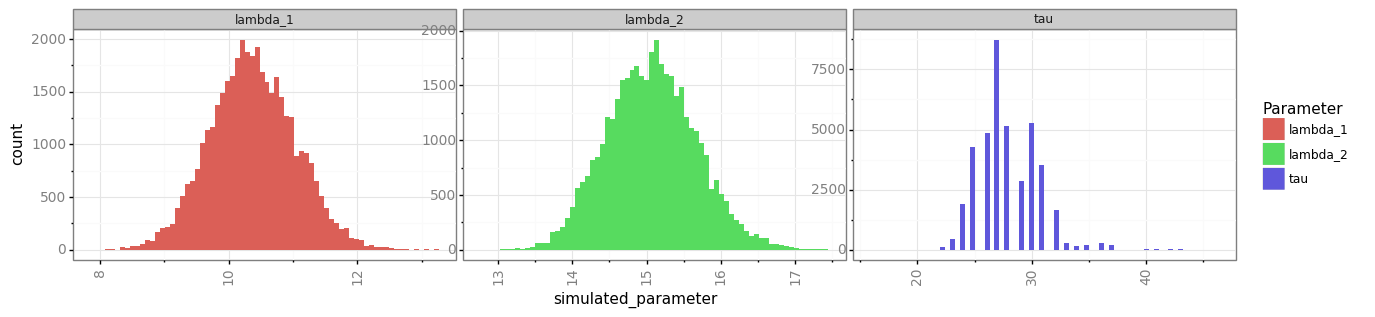

<ggplot: (-9223372036516029864)>

In [22]:
# Plot options
pn.options.figure_size = (15,3)
pn.options.dpi = 100

# Plotting distribution
ggplot(aes(x = 'simulated_parameter', fill = 'Parameter'), data = posterior_dist)\
+ geom_histogram(bins = 70)\
+ facet_wrap(['Parameter'],scales='free')\
+ theme_bw()\
+ theme(axis_text_x = element_text(color="grey", size=10, angle=90, hjust=.5),
        axis_text_y = element_text(color="grey", size=10))

### What are good estimates for the visitor rates and switch point day?

In [23]:
# Rounding to nearest 100th
posterior_dist['simulated_parameter'] = np.round(posterior_dist['simulated_parameter'],2)

# Getting MAP estimates of simulated values
MAP_estimates = posterior_dist.groupby('Parameter').simulated_parameter.agg(pd.Series.mode)

# Getting the summarized values
out = '''
---------------------------------------------------------------------
The MAP estimate for the switch point is at {switch_point_time}.
The MAP estimate for the rate BEFORE the switch point is {lambda_1}.
The MAP estimate for the rate AFTER the switch point is {lambda_2}.
---------------------------------------------------------------------
'''.format(switch_point_time = MAP_estimates.tau,
          lambda_1 = MAP_estimates.lambda_1,
          lambda_2 = MAP_estimates.lambda_2,)
print(out)
# pm.find_MAP(model=model)


---------------------------------------------------------------------
The MAP estimate for the switch point is at 27.0.
The MAP estimate for the rate BEFORE the switch point is 10.2.
The MAP estimate for the rate AFTER the switch point is 15.11.
---------------------------------------------------------------------



### How many expected visitors do we have per day?

In [24]:
posterior_dist['simulated_parameter'].shape

(120000,)

In [25]:
# - Average rate: across time -
daily_expected_visitors = np.zeros(l)
n_samples = posterior_dist['simulated_parameter'].shape[0]

for day in range(0,l):
    ix = day < tau_samples
    daily_expected_visitors[day] = (lambda_1_samples[ix].sum() + lambda_2_samples[~ix].sum())/n_samples


In [26]:
df_daily_expected_visitors = pd.DataFrame({'daily_expected_visitors': daily_expected_visitors})
posterior_count_data = pd.concat([count_data,df_daily_expected_visitors],axis =1)

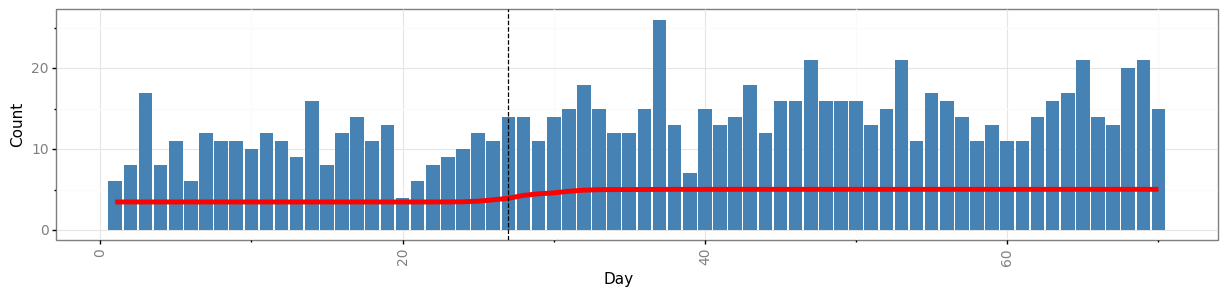

<ggplot: (308122523)>

In [27]:
# Plotting mean visitor rate
ggplot(aes(x = 'time', y ='observed_counts'), data = posterior_count_data)\
+ geom_bar(stat='identity', fill = 'steelblue')\
+ geom_line(aes(x = 'time',y = 'daily_expected_visitors'), color='red', size = 2)\
+ theme_bw()\
+ theme(axis_text_x = element_text(color="grey", size=10, angle=90, hjust=.5),
        axis_text_y = element_text(color="grey", size=10))\
+ geom_vline(xintercept = MAP_estimates.tau, color='black', linetype = 'dashed' )\
+ xlab('Day') + ylab('Count')

### Are the two rates statistically different?
- We can calculate this using the simulated values

In [28]:
# - Difference in rates -
lambda_1_values = trace.get_values('lambda_1', burn=1000, chains=[0, 1])
lambda_2_values = trace.get_values('lambda_2', burn=1000, chains=[0, 1])
probability_lambdas_are_different = (lambda_1_values < lambda_2_values).mean()
#print('The probability the two rates are different is: {}'.format(probability_lambdas_are_different))

### What's the probability that $\lambda_1<\lambda_2$ by more than $\Delta$

In [29]:
for delta in [1,2,3,4,5,7]:
    prob_lambdas_differ_by_delta = (lambda_1_values + delta < lambda_2_values).mean()
    if(delta == 1):
        print('Pr(lambda_1+Delta<lambda_2):')
    else:
        print('{d} is: {p}'.format(d = delta,p = prob_lambdas_differ_by_delta))

Pr(lambda_1+Delta<lambda_2):
2 is: 0.9987222222222222
3 is: 0.9734444444444444
4 is: 0.7818333333333334
5 is: 0.35338888888888886
7 is: 0.0034444444444444444
